# Zustandsreglerentwurf

In [1]:
# 3rd party imports
import control
from IPython.display import display, Image, Latex, Markdown
import numpy as np
import sympy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# user imports
import settingsV1 as st

## Theoretische Betrachtung

### Theorie dahinter

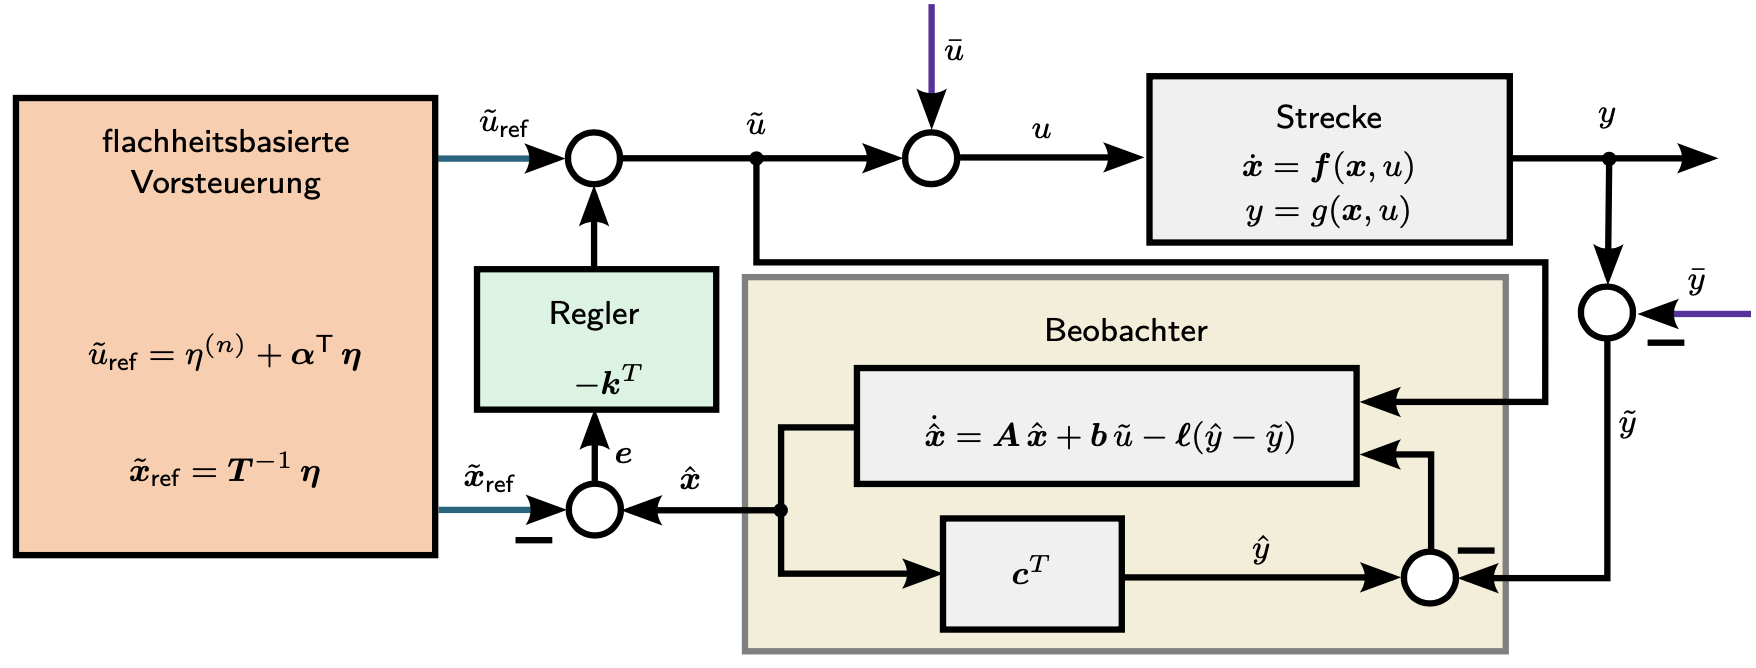

In [2]:
imag = Image("../images/zustandsregler_beobachter_vorsteuerung.png", width=600)
display(imag)

Ziel ist der Entwurf eines Zustandsreglers auf Basis des linearisierten Modells des Zweitanksystems.

Dabei wird eine Zustandsrückführung durchgeführt. Diese kann wie folgt entworfen werden:

1. Berechnung der Zustandstransformation:
    
    a) Berechnung der Kalmanschen Steuerbarkeitsmatrix

    \begin{align*}
        S = \left(\mathbf{b}, A\mathbf{b}, \dots, A^{n-1}\mathbf{b} \right)
    \end{align*}

    b) $\mathbf{q}_1^T$ ist die letzte Zeile der inversen von $S$

    c) Berechnung der Transformationsmatrix $Q$

\begin{align*}
\begin{pmatrix} 
q^T\\
q^T A \\
\vdots \\
q^T A^{n-1}
\end{pmatrix}
\end{align*}

2. Berechnung der Zustandsrückführung
\begin{align*}
    u = -\overline{\mathbf{k}}^T \cdot \overline{\mathbf{x}} = -\overline{\mathbf{k}}^T Q \mathbf{x}
\end{align*}

Die Verstärkungen $\overline{\mathbf{k}}^T$ kann über die Ackermannformel berechnet werden.

In [3]:
# symbole definieren
alpha1, alpha2, x1, x2, Ku, AT1, AT2, AS1, AS2, uA, hV1, hV2, g = sp.symbols('alpha_1, alpha_2, x_1, x_2, K_u, A_{T1}, A_{T2}, A_{S1}, A_{S2}, u_A, h_{V1}, h_{V2}, g')

### nichtlineares System

Liegt in Form der Differentialgleichungen vor:

\begin{align*}
    dx_1 &= - A_{S,1} \sqrt{\frac{2g (x_1 + h_{V,1})}{A_{T,1}^2 - A_{S,1}^2}} + \frac{K_u}{A_{T,1}} u_A \\

    dx_2 &= \frac{A_{S,1} A_{T,1}}{A_{T,2}} \sqrt{\frac{2g (x_1 + h_{V,1})}{A_{T,1}^2 - A_{S,1}^2}} - A_{S,2} \sqrt{\frac{2g (x_2 + h_{V,2})}{A_{T,2}^2 - A_{S,2}^2}}
\end{align*}

mit 

\begin{align*}
    \dot{\mathbf{x}}(t) = 
    \begin{pmatrix}
    dx_1 \\
    dx_2
    \end{pmatrix}
\end{align*}

In [4]:
dx1 = - AS1 * sp.sqrt(2 * g / (AT1**2 - AS1**2)) * sp.sqrt(x1 + hV1) + Ku / AT1 * uA
dx2 = - AS2 * sp.sqrt(2 * g / (AT2**2 - AS2**2)) * sp.sqrt(x2 + hV2) + AS1 * sp.sqrt(2 * g / (AT1**2 - AS1**2)) * sp.sqrt(x1 + hV1) * AT1 / AT2

dx = sp.Matrix([[dx1], [dx2]]);

### Linearisierung des Systems:

Durch Nullsetzen der Ableitung in der Form $\dot{\mathbf{x}}(t) \stackrel{!}{=} 0$ werden die Ruhelagen berechnet. Um nun eine konkrete Linearisierung durchzuführen, wird ein Wert gewählt, um den linearisiert wird. Aus diesem Grund wird $\overline{u}$ als Ruhelage vorgegeben und die anderen beiden Größen daraus berechnet, in der Form:

\begin{align*}
    \bar{x}_1 &= \frac{(A_{T,1}^2 - A_{S,1}^2) K_u^2}{2 (A_{T,1} A_{S,1})^2 g} \bar{u}^2 - h_{V,1} \\
    \bar{x}_2 &= \left(\frac{A_{T,1} A_{S,1}}{A_{T,2} A_{S,2}}\right)^2 \frac{A_{T,2}^2 - A_{S,2}^2}{A_{T,1}^2 - A_{S,1}^2} (\bar{x}_1 + h_{V,1}) - h_{V,2}
\end{align*}

In [5]:
u_quer = sp.symbols('u_{quer}')
x1_quer = ((AT1**2 - AS1**2) * Ku**2) / (2 * (AT1 * AS1)**2 * g) * u_quer**2 - hV1
x2_quer = ((AT1 * AS1) / (AT2 * AS2))**2 * (AT2**2 - AS2**2) / (AT1**2 - AS1**2) * (x1_quer + hV1) - hV2

# Linearisierung um die gewählte Ruhelage u_quer
alpha1 = AS1 * sp.sqrt(g / (2 * (x1_quer + hV1) * (AT1**2 - AS1**2)))
alpha2 = AS2 * sp.sqrt(g / (2 * (x2_quer + hV2) * (AT2**2 - AS2**2)))


x = sp.Matrix([[x1], [x2]]);
A = sp.Matrix([[-alpha1, 0], [AT1/AT2 * alpha1, -alpha2]])
b = sp.Matrix([[Ku/AT1], [0]])
cT = sp.Matrix([[0, 1]])

Damit erhalten wir folgendes System, linearisiert um die Ruhelage $\overline{u}$. Dafür werden die neuen Koordinaten wie folgt eingeführt: 
\begin{align*}
\Delta x(t) &= x(t) - \bar{x} \\
\Delta u(t) &= u(t) - \bar{u}
\end{align*}

Das linearisierte System ist damit in Zustandsraumdarstellung wie folgt gegeben:
\begin{align*}
    \Delta \dot{x}(t) &= A \cdot \Delta x(t) + b \cdot \Delta u(t) \\
    y(t) &= c^T \Delta x(t)
\end{align*}

Ausgeschrieben erhält man so das System:

\begin{align*}

\Delta \dot{x}(t) = 
\begin{bmatrix} 
-\alpha_1 & 0 \\
\frac{A_{T,1}}{A_{T,2}} \cdot \alpha_1 & -\alpha_2
\end{bmatrix}
\cdot \Delta x(t) + 
\begin{bmatrix} 
\frac{K_u}{A_{T,1}} \\
0
\end{bmatrix}
\cdot \Delta u(t)

\end{align*}

\begin{align*}
\Delta y(t) =
\begin{bmatrix}
0 & 1
\end{bmatrix}
\cdot \Delta x(t)
\end{align*}

mit 

\begin{align*}
\alpha_1 = A_{ab,1} \cdot \sqrt{\frac{g}{2\left(\overline{z}_1+\overline{h}_{V,1}\right)\left(A^2_{T,1}-A^2_{ab,1}\right)}}
\end{align*}

\begin{align*}
\alpha_2 = A_{ab,2} \cdot \sqrt{\frac{g}{2\left(\overline{z}_2+\overline{h}_{V,2}\right)\left(A^2_{T,2}-A^2_{ab,2}\right)}}
\end{align*}

### Transformation des Systems in RNF

Entsprechend der oben beschriebenen Vorgehensweise wird nun das linearisierte System in die Regelungsnormalform (RNF) transformiert:

In [6]:
# Berechnung der Steuerbarkeitsmatrix
S = sp.Matrix(sp.BlockMatrix([b, A*b]))

# Berechnung des Vektors
qT = S.inv()[-1, :]

# Berechnung der Transformationsmatrix Q (in die RNF)
Q = sp.Matrix(sp.BlockMatrix([[qT], [qT * A]]))

# Transformation des Systems in RNF
A_rnf = Q * A * Q.inv()
b_rnf = Q * b
cT_rnf = cT * Q.inv()

### Übergang zu numerischen Werten

In [7]:
# diese Werte werden nachher benötigt, um die Symbole zu ersetzen
settings = {AS1: st.AS1, 
            AS2: st.AS2, 
            AT1: st.AT1, 
            AT2: st.AT2, 
            g: st.g, 
            Ku: st.Ku, 
            hV1: st.hV1, 
            hV2: st.hV2, 
            uA: st.uA0, 
            u_quer:2.6        # entspricht also 6.4 (=uA0) + 2.6 = 9V; um diesen Wert wird linearisiert
            }

In [8]:
# Berechnung der Matrizen
A_num = A.subs(settings)
b_num = b.subs(settings)
cT_num = cT.subs(settings)

# Berechnung der transformierten Matrizen
A_rnf_num = A_rnf.subs(settings)
b_rnf_num = b_rnf.subs(settings)
Q_num = np.matrix(Q.subs(settings))
Q_inv_num = np.matrix(Q.inv().subs(settings))

# dementsprechend auch die Ruhelagen für x1 und x2 quer berechnen
# Achtung: das ist der Ruhelagewert in den ursprünglichen nichtlinearen Koordinaten
x1_quer_num = x1_quer.subs(settings)
x2_quer_num = x2_quer.subs(settings)
u_quer_num = u_quer.subs(settings)

In [9]:
# Vorgabe von geeigneten Polen für die Ackermannformel
poles = [-0.5, -1]
kT = control.acker(A_rnf_num, b_rnf_num, poles)

## Simulation

### Definitionen

Definition nichtlineares Modell

In [10]:
def nonLinSys(t, z, uA):
    z1 = z[0]
    z2 = z[1]

    if z1 < 0:
        z1 = 0

    if z2 < 0:
        z2 = 0
        
    hV1 = 0.055
    hV2 = 0.055
    
    dz = np.zeros(2)
    dz[0] = 0.00216625315586689 * (uA - 6.4) - 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1)
    dz[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(hV2 + z2)

    return dz

Definition linearisiertes Modell

In [11]:
def linSys(t, x, uA):
    if x[0] < 0:
        x[0] = 0

    if x[0] < 0:
        x[0] = 0

    # der Zustand muss in die linearisierten Koordinaten (oben mit den Delta Koordinaten bezeichnet) gebracht werden:
    Delta_x = np.array([[x[0] -  x1_quer_num], [x[1] -  x2_quer_num]])

    Delta_u = uA - u_quer_num

    dx = A_num@Delta_x + b_num * (Delta_u - 6.4)
    return np.reshape(dx, -1)

Definition Steuerung

In [12]:
class Steuerung:
    def __init__(self, z20, z21, t0, t1, T1, T2, K):
        self.z20 = z20
        self.z21 = z21
        self.t0 = t0
        self.t1 = t1
        self.dt = t1 - t0
        self.a0 = 1 / (T1 * T2)
        self.a1 = (T1 + T2) / (T1 * T2)
        self.b = K / (T1 * T2)

        tau = sp.symbols('\\tau')
        self.phi = 6 * tau ** 5 - 15 * tau ** 4 + 10 * tau ** 3
        self.dphi = self.phi.diff(tau)
        self.ddphi = self.phi.diff(tau, 2)
        
        self.z2r = lambda t: self.z20 + (self.z21 - self.z20) * self.phi.subs({tau: t / self.dt}) if 0 <= t <= self.dt else z20 if t < 0 else self.z21 
        self.dz2r = lambda t: (self.z21 - self.z20) * self.dphi.subs({tau: t / self.dt}) / self.dt if 0 < t < self.dt else 0
        self.ddz2r = lambda t: (self.z21 - self.z20) * self.ddphi.subs({tau: t / self.dt}) / self.dt ** 2 if 0 < t < self.dt else 0
        self.uAr = lambda t: 1/ self.b * (self.ddz2r(t) + self.a1 * self.dz2r(t) + self.a0 * self.z2r(t))

    def run(self, t):
        return self.z2r(t), self.dz2r(t), self.uAr(t)    

Definition Regler

In [13]:
# gib mir alles nichtlinear und ich gebe nichtlinear zurück
class ReglerZustand:
    def __init__(self, kT):
        self.kT = kT[0]

    def run(self, x):

        return -self.kT * x

In [14]:
# Physikalisch
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz2Phy = 0.137092448385557
# Messung
KMessung = 0.05335540886113588
T1Messung = 11.796537856412515
T2Messung = 80.74097989401139
bz2Messung = 0.13238994944989588
z2Soll = 0.12

In [15]:
timeDom = np.linspace(0, 200, 1001)
z0 = [0, 0]
dt = 150

regler = ReglerZustand(kT)
steuerung = Steuerung(0 - x2_quer_num, 0.12 - x2_quer_num, 0, dt, T1Messung, T2Messung, KMessung)

### Regler ohne Steuerung

#### Simulation

**Model nlin (ohne Steuerung):**

Der Zustandsregler kriegt den nichtlinearisierten Systemzustand. Dieser muss in die linearisierten Koordinaten gebracht werden und durch die $Q$ Matrix in die RNF transformiert werden.

Dieser Fehler ist im Falle eines Zustandsreglers zweidimensional. Er wird anschließend mit dem kT multipliziert, was den Reglerausgang ergibt. Die Zustände, welche verwendet werden um den Fehler zu berechnen müssen deshalb transformiert werden, da auch die Matrizen, welche zur Berechnung der Reglerverstärkung kT herangezogen wurden, in der RNF waren.

Auf den Reglerausgang muss dann noch der Anteil der Linearisierung dazuaddiert werden, um den Output in nichtlinearen Koordinaten zu erhalten.

In [16]:
# Simulation nichtlineares Modell
zNichtLin = np.zeros((2, len(timeDom)))
uNichtLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0NichtLin = zNichtLin[:, idx]

    # der Zustand muss in die linearisierten Koordinaten (oben mit den Delta Koordinaten bezeichnet) gebracht werden:
    Delta_x_1 = z0NichtLin[0] -  x1_quer_num
    Delta_x_2 = z0NichtLin[1] -  x2_quer_num
    Delta_x = [[Delta_x_1], [Delta_x_2]]
    
    x_rnf = Q_num * Delta_x
    
    uNichtLin[idx] = regler.run(x_rnf)

    # die Spannung (bis jetzt in den linearen Koordinaten) in die nlin Koordinaten überführen
    uNichtLin[idx] += u_quer_num

    # die Grundspannung dazuaddieren
    uNichtLin[idx] += st.uA0

    # Stellgrößenbeschränkung
    if uNichtLin[idx] < 0:
        uNichtLin[idx] = 0
    elif uNichtLin[idx] > 12:
        uNichtLin[idx] = 12

    resNichtLin = solve_ivp(nonLinSys, [timeDom[idx], timeDom[idx + 1]], z0NichtLin, args=(uNichtLin[idx],))
    zNichtLin[:, idx + 1] = resNichtLin.y.T[-1, :]

**Model lin (ohne Steuerung):**

Der implementierte Zustandsregler erwartet den übergebenen Zustand in nichtlinearen Koordinaten, da er sie intern umrechnet. Aus diesem Grund muss man sich also vergewissern, dass man ihm den richtigen Zustand übergibt.

In [17]:
# Simulation linearisiertes Modell
zLin = np.zeros((2, len(timeDom)))
uLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0Lin = zLin[:, idx]

    # der Zustand muss in die linearisierten Koordinaten (oben mit den Delta Koordinaten bezeichnet) gebracht werden:
    Delta_x_1 = z0Lin[0] -  x1_quer_num
    Delta_x_2 = z0Lin[1] -  x2_quer_num
    Delta_x = [[Delta_x_1], [Delta_x_2]]
    
    x_rnf = Q_num * Delta_x
    
    uLin[idx] = regler.run(x_rnf)

    # die Spannung (bis jetzt in den linearen Koordinaten) in die nlin Koordinaten überführen
    uLin[idx] += u_quer_num

    # die Grundspannung dazuaddieren
    uLin[idx] += st.uA0

    # Stellgrößenbeschränkung
    if uLin[idx] < 0:
        uLin[idx] = 0
    elif uLin[idx] > 12:
        uLin[idx] = 12

    resLin = solve_ivp(linSys, [timeDom[idx], timeDom[idx + 1]], z0Lin, args=(uLin[idx],))
    zLin[:, idx + 1] = resLin.y.T[-1, :]

#### Ergebnisse

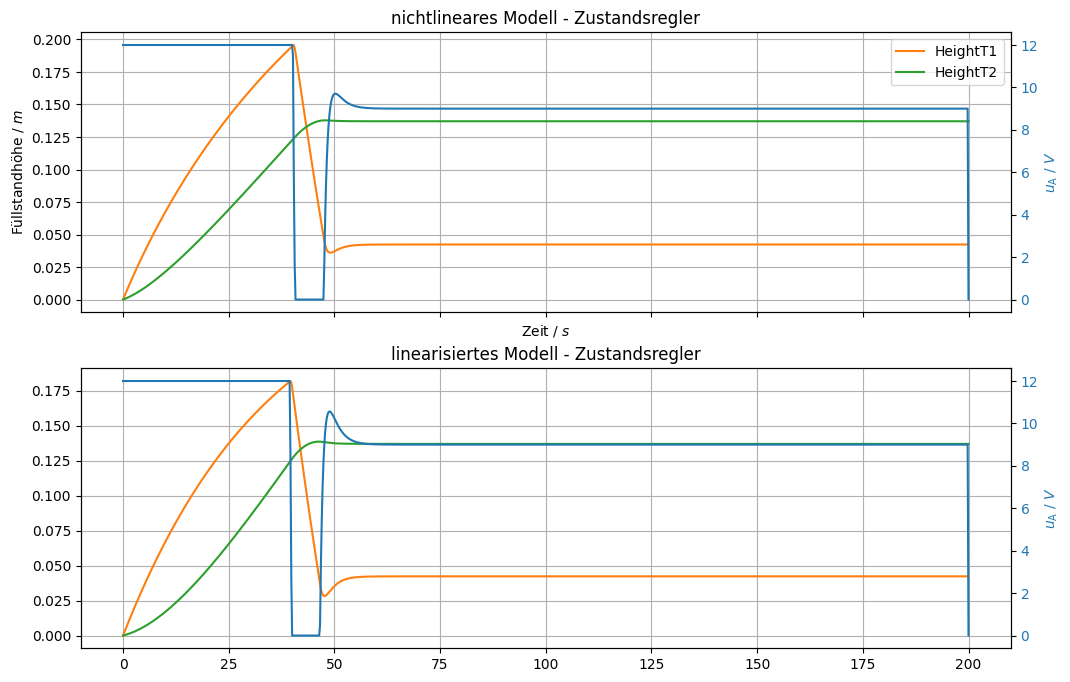

In [18]:
plt.close()

fig, (axes10, axes20) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

axes10.plot(timeDom, zNichtLin[0,:], label='HeightT1', color='tab:orange')
axes10.plot(timeDom, zNichtLin[1,:], label='HeightT2', color='tab:green')
axes20.plot(timeDom, zLin[0,:], label='HeightT1', color='tab:orange')
axes20.plot(timeDom, zLin[1,:], label='HeightT2', color='tab:green')

axes11 = axes10.twinx()
axes21 = axes20.twinx()

axes11.plot(timeDom, uNichtLin, label='Spannung', color='tab:blue')
axes21.plot(timeDom, uLin, label='Spannung', color='tab:blue')

axes11.tick_params(axis='y', labelcolor='tab:blue')
axes21.tick_params(axis='y', labelcolor='tab:blue')

axes11.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='tab:blue')
axes21.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='tab:blue')

axes10.set_xlabel(r'Zeit / $s$')
axes10.set_ylabel(r'Füllstandhöhe / $m$')

axes10.legend()

axes10.title.set_text('nichtlineares Modell - Zustandsregler')
axes20.title.set_text('linearisiertes Modell - Zustandsregler')

axes10.grid()
axes20.grid()

plt.show()

### Regler mit Steuerung

#### Steuerung

Stelle sicher, dass die Steuerung auf Basis der linearisierten Koordinaten entworfen wird

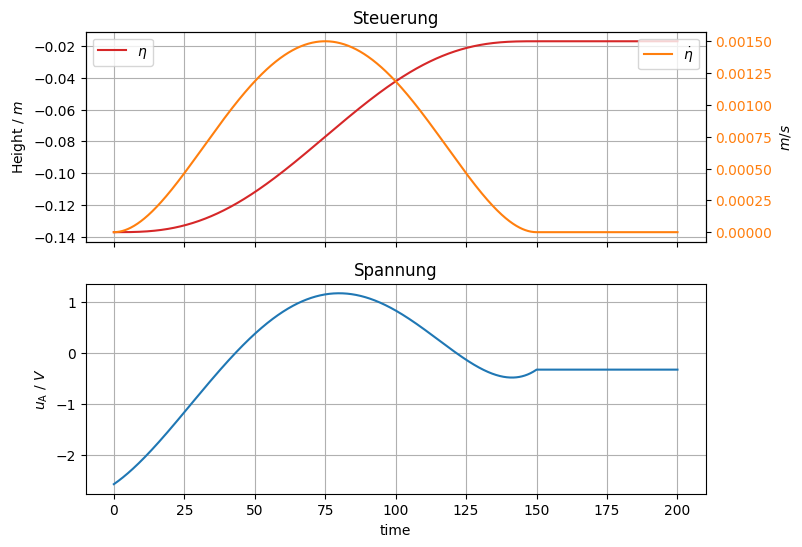

In [19]:
# Visualisierung der Steuerung
eta = []
deta = []
eingang_steuerung = []
for idx, _t in enumerate(timeDom):
    z2r, dz2r, uSteuerung = steuerung.run(_t)
    eta.append(z2r)
    deta.append(dz2r)
    eingang_steuerung.append(uSteuerung)

plt.close()

fig, (axes10, axes20) = plt.subplots(2, 1, figsize=(8,6), sharex=True)
axes10.plot(timeDom, eta, label=r'$\eta$', color='tab:red')
axes11 = axes10.twinx()

axes11.plot(timeDom, deta, label=r'$\dot{\eta}$', color='tab:orange')
axes20.plot(timeDom, eingang_steuerung)

axes11.tick_params(axis='y', labelcolor='tab:orange')
axes20.set_ylabel(r'$u_{\mathrm{A}}$ / $V$')
axes10.set_ylabel(r'Height / $m$')
axes11.set_ylabel(r'$m/s$')
axes20.set_xlabel('time')

axes10.legend()
axes11.legend()
axes10.title.set_text('Steuerung')
axes20.title.set_text('Spannung')

axes10.grid(True)
axes20.grid(True)

plt.show()

#### Simulation

**Model nlin (Regler und Steuerung):**

Die etas, die mir die Steuerung liefert sind bereits in den korrekten Koordinaten und ich muss sie dementspechend nicht mit der Q-Matrix transformieren.

Auf den Reglerausgang muss dann noch der Anteil der Steuerung und jener der Linearisierung dazuaddiert werden.

In [20]:
# Simulation nichtlineares Modell
zNichtLin = np.zeros((2, len(timeDom)))
uNichtLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):

    ########### SYSTEMZUSTAND ###########
    z0NichtLin = zNichtLin[:, idx]

    # der Zustand muss in die linearisierten Koordinaten (oben mit den Delta Koordinaten bezeichnet) gebracht werden:
    Delta_x_1 = z0NichtLin[0] -  x1_quer_num
    Delta_x_2 = z0NichtLin[1] -  x2_quer_num
    Delta_x = [[Delta_x_1], [Delta_x_2]]
    
    # Transformation in RNF
    x_rnf = Q_num * Delta_x

    ########### STEUERUNG ###########
    z2r, dz2r, uSteuerung = steuerung.run(_t)
    
    x_ref_rnf = [[z2r], [dz2r]]
    
    ########### BERECHNUNG REGELUNG ###########
    uNichtLin[idx] = regler.run(x_rnf - x_ref_rnf)

    # Addieren der Anteil Steuerung
    uNichtLin[idx] += uSteuerung

    # # die Spannung (bis jetzt in den linearen Koordinaten) in die nlin Koordinaten überführen
    uNichtLin[idx] += u_quer_num

    # die Grundspannung dazuaddieren
    uNichtLin[idx] += st.uA0

    # Stellgrößenbeschränkung
    if uNichtLin[idx] < 0:
        uNichtLin[idx] = 0
    elif uNichtLin[idx] > 12:
        uNichtLin[idx] = 12

    resNichtLin = solve_ivp(nonLinSys, [timeDom[idx], timeDom[idx + 1]], z0NichtLin, args=(uNichtLin[idx],))
    zNichtLin[:, idx + 1] = resNichtLin.y.T[-1, :]

**Model lin (mit Steuerung, ohne Regler):**

In [21]:
# Simulation nichtlineares Modell
zLin_no_ctrl = np.zeros((2, len(timeDom)))
uLin_no_ctrl = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):

    ########### SYSTEMZUSTAND ###########
    z0Lin_no_ctrl = zLin_no_ctrl[:, idx]

    ########### STEUERUNG ###########
    _, _, uSteuerung = steuerung.run(_t)

    # Spannung der Steuerung dazuaddieren
    uLin_no_ctrl[idx] = uSteuerung

    # # die Spannung (bis jetzt in den linearen Koordinaten) in die nlin Koordinaten überführen
    uLin_no_ctrl[idx] += u_quer_num

    # die Grundspannung dazuaddieren
    uLin_no_ctrl[idx] += st.uA0

    # Stellgrößenbeschränkung
    if uLin_no_ctrl[idx] < 0:
        uLin_no_ctrl[idx] = 0
    elif uLin_no_ctrl[idx] > 12:
        uLin_no_ctrl[idx] = 12

    resLin_no_ctrl = solve_ivp(linSys, [timeDom[idx], timeDom[idx + 1]], z0Lin_no_ctrl, args=(uLin_no_ctrl[idx],))
    zLin_no_ctrl[:, idx + 1] = resLin_no_ctrl.y.T[-1, :]

**Model lin (mit Steuerung, mit Regler):**

In [22]:
# Simulation nichtlineares Modell
zLin = np.zeros((2, len(timeDom)))
uLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):

    ########### SYSTEMZUSTAND ###########
    z0Lin = zLin[:, idx]

    # der Zustand muss in die linearisierten Koordinaten (oben mit den Delta Koordinaten bezeichnet) gebracht werden:
    Delta_x_1 = z0Lin[0] -  x1_quer_num
    Delta_x_2 = z0Lin[1] -  x2_quer_num
    Delta_x = [[Delta_x_1], [Delta_x_2]]
    
    # Transformation in RNF
    x_rnf = Q_num * Delta_x

    ########### STEUERUNG ###########
    z2r, dz2r, uSteuerung = steuerung.run(_t)
    
    x_ref_rnf = [[z2r], [dz2r]]
    
    ########### BERECHNUNG REGELUNG ###########
    uLin[idx] = regler.run(x_rnf - x_ref_rnf)

    # Addieren Anteil Steuerung
    uLin[idx] += uSteuerung

    # die Spannung (bis jetzt in den linearen Koordinaten) in die nlin Koordinaten überführen
    uLin[idx] += u_quer_num

    # die Grundspannung dazuaddieren
    uLin[idx] += st.uA0

    # Stellgrößenbeschränkung
    if uLin[idx] < 0:
        uLin[idx] = 0
    elif uLin[idx] > 12:
        uLin[idx] = 12

    resLin = solve_ivp(linSys, [timeDom[idx], timeDom[idx + 1]], z0Lin, args=(uLin[idx],))
    zLin[:, idx + 1] = resLin.y.T[-1, :]

#### Ergebnisse

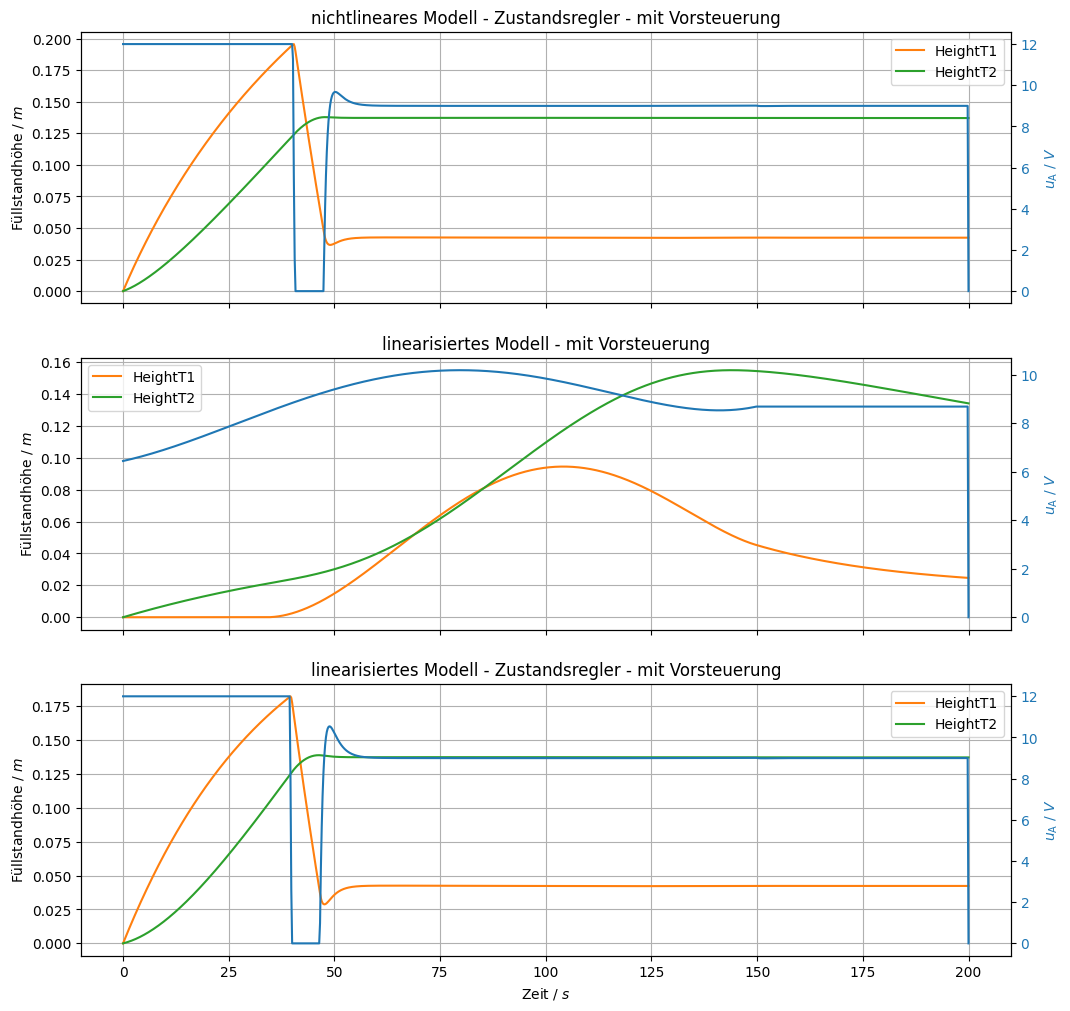

In [23]:
plt.close()

fig, (axes10, axes20, axes30) = plt.subplots(3, 1, figsize=(12,12), sharex=True)

axes10.plot(timeDom, zNichtLin[0,:], label='HeightT1', color='tab:orange')
axes10.plot(timeDom, zNichtLin[1,:], label='HeightT2', color='tab:green')
axes20.plot(timeDom, zLin_no_ctrl[0,:], label='HeightT1', color='tab:orange')
axes20.plot(timeDom, zLin_no_ctrl[1,:], label='HeightT2', color='tab:green')
axes30.plot(timeDom, zLin[0,:], label='HeightT1', color='tab:orange')
axes30.plot(timeDom, zLin[1,:], label='HeightT2', color='tab:green')

axes11 = axes10.twinx()
axes21 = axes20.twinx()
axes31 = axes30.twinx()

axes11.plot(timeDom, uNichtLin, label='Spannung', color='tab:blue')
axes21.plot(timeDom, uLin_no_ctrl, label='Spannung', color='tab:blue')
axes31.plot(timeDom, uLin, label='Spannung', color='tab:blue')

axes11.tick_params(axis='y', labelcolor='tab:blue')
axes21.tick_params(axis='y', labelcolor='tab:blue')
axes31.tick_params(axis='y', labelcolor='tab:blue')

axes11.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='tab:blue')
axes21.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='tab:blue')
axes31.set_ylabel(r'$u_{\mathrm{A}}$ / $V$', color='tab:blue')

axes30.set_xlabel(r'Zeit / $s$')
axes10.set_ylabel(r'Füllstandhöhe / $m$')
axes20.set_ylabel(r'Füllstandhöhe / $m$')
axes30.set_ylabel(r'Füllstandhöhe / $m$')

axes10.legend()
axes20.legend()
axes30.legend()

axes10.title.set_text('nichtlineares Modell - Zustandsregler - mit Vorsteuerung')
axes20.title.set_text('linearisiertes Modell - mit Vorsteuerung')
axes30.title.set_text('linearisiertes Modell - Zustandsregler - mit Vorsteuerung')

axes10.grid()
axes20.grid()
axes30.grid()

plt.show()